# Sign Language Dataset

The Sign Language Dataset consists of 9680 grayscale images of hand signs for the digits 0-9 and the alphabets a-z. Thus, this is a multiclass classification problem with 36 classes. Your task is to build a machine learning model that can accurately classify images from this dataset.

## Loading the dataset

You **do not** need to upload any data. Both the visible training dataset and the hidden test dataset are already available on the Jupyter hub.

In [3]:
import os
import csv
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Setting the path of the training dataset (that was already provided to you)

running_local = True if os.getenv('JUPYTERHUB_USER') is None else False
DATASET_PATH = "."

# Set the location of the dataset
if running_local:
    # If running on your local machine, the sign_lang_train folder's path should be specified here
    local_path = "./data/sign_lang_train"
    if os.path.exists(local_path):
        DATASET_PATH = local_path
else:
    # If running on the Jupyter hub, this data folder is already available
    # You DO NOT need to upload the data!
    DATASET_PATH = "/data/mlproject22/sign_lang_train"

In [5]:
# Utility function

def read_csv(csv_file):
    with open(csv_file, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
    return data

## Data Loading using PyTorch

For creating and training your model, you can work with any machine learning library of your choice. 

If you choose to work with [PyTorch](https://pytorch.org/), you will need to create your own [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class for loading the data. This is provided below. See [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) for a nice example of how to create a custom data loading pipeline in PyTorch. 

In [45]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils, io
from torchvision.utils import make_grid
from PIL import Image

from string import ascii_lowercase

class SignLangDataset(Dataset):
    """Sign language dataset"""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = read_csv(os.path.join(root_dir,csv_file))
        self.root_dir = root_dir
        self.transform = transform
        # List of class names in order
        self.class_names = list(map(str, list(range(10)))) + list(ascii_lowercase)

    def __len__(self):
        """
        Calculates the length of the dataset-
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns one sample (dict consisting of an image and its label)
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read the image and labels
        image_path = os.path.join(self.root_dir, self.data[idx][1])
        
        # Read image as a grayscale PIL image
        image = Image.open(image_path).convert("L")  # 'L' = grayscale mode

        if self.transform:
            image = self.transform(image)

        # The label is the index of the class name in the list ['0','1',...,'9','a','b',...'z']
        # because we should have integer labels in the range 0-35 (for 36 classes)
        label = self.class_names.index(self.data[idx][0])
        
        sample = {'image': image, 'label': label}

        return sample
    
    def show_sample(self, idx: int) -> None:
        """
        Displays a grayscale image with its corresponding class label (0-35).
        
        Args:
            image (numpy.ndarray): The image to display. Shape should be (1, H, W) or (H, W).
            label (int): Integer label in range 0-35.
        """

        sample = self[idx]
        image = sample["image"]
        label_index = sample["label"]
        label = self.class_names[label_index]

        # Flatten channel dimension if needed
        if image.ndim == 3 and image.shape[0] == 1:
            image = image[0] 
        
        plt.imshow(image, cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
        plt.show()

# Define label mapping
class_names = list(map(str, range(10))) + list(ascii_lowercase)

# Transform Images to 128x128
transform = transforms.Compose([
    transforms.ToTensor(),                   # Converts HxW numpy → CxHxW tensor
    transforms.Resize((128, 128)),           # Resize to 128x128
])

sign_dataset = SignLangDataset("labels.csv", os.path.join(DATASET_PATH, "images"), transform)

### Test Train Data Split


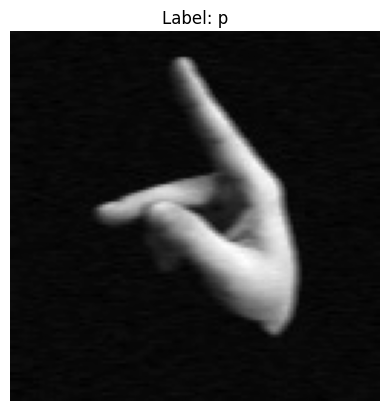

In [46]:
# Define split sizes
val_size = int(0.2 * len(sign_dataset))
train_size = len(sign_dataset) - val_size

# Split the dataset
generator = torch.Generator().manual_seed(42) # for reproducability
train_dataset, val_dataset = random_split(sign_dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

sign_dataset.show_sample(2320)

### CNN

In [47]:
import torch.nn as nn
import torch.nn.functional as F

class SignLangCNN(nn.Module):
    def __init__(self, num_classes=36):
        super(SignLangCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # [B, 32, 128, 128]
        self.pool1 = nn.MaxPool2d(2, 2)                           # [B, 32, 64, 64]

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # [B, 64, 64, 64]
        self.pool2 = nn.MaxPool2d(2, 2)                           # [B, 64, 32, 32]

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # [B, 128, 32, 32]
        self.pool3 = nn.MaxPool2d(2, 2)                           # [B, 128, 16, 16]

        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))  # [B, 32, 64, 64]
        x = self.pool2(F.relu(self.conv2(x)))  # [B, 64, 32, 32]
        x = self.pool3(F.relu(self.conv3(x)))  # [B, 128, 16, 16]
        x = x.view(x.size(0), -1)              # flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)                        # logits
        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SignLangCNN(num_classes=36)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [49]:
def evaluate_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    return correct / total

val_acc = evaluate_accuracy(model, val_loader, device)
print(f"Validation Accuracy: {val_acc:.2%}")

Validation Accuracy: 82.23%


In [48]:
torch.save(model.state_dict(), "sign_lang_model.pt")

val_acc = evaluate_accuracy(model, train_loader, device)
print(f"Validation Accuracy: {val_acc:.2%}")

Validation Accuracy: 89.72%


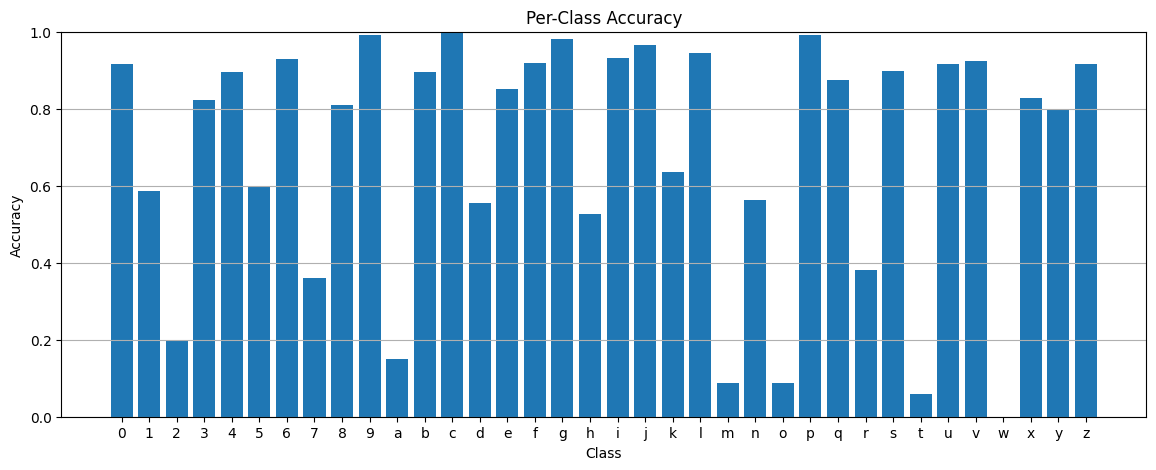

In [50]:
def plot_per_class_accuracy(model, dataloader, device, num_classes=36, class_names=None):
    """
    Evaluates and plots per-class accuracy for a classification model.

    Args:
        model: Trained PyTorch model.
        dataloader: DataLoader for validation/test set.
        device: 'cuda' or 'cpu'.
        num_classes: Total number of classes.
        class_names: Optional list of class labels. If None, uses ['0'-'9'] + ['a'-'z'].
        show_worst_n: Number of lowest-performing classes to print.
    """
    if class_names is None:
        class_names = list(map(str, range(10))) + list(ascii_lowercase)

    model.eval()
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for label, pred in zip(labels, preds):
                class_total[label] += 1
                if label == pred:
                    class_correct[label] += 1

    per_class_accuracy = [correct / total if total != 0 else 0.0
                          for correct, total in zip(class_correct, class_total)]

    plt.figure(figsize=(14, 5))
    plt.bar(class_names, per_class_accuracy)
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.title("Per-Class Accuracy")
    plt.ylim(0, 1.0)
    plt.grid(axis='y')
    plt.show()

plot_per_class_accuracy(model, val_loader, device, 36, sign_dataset.class_names)

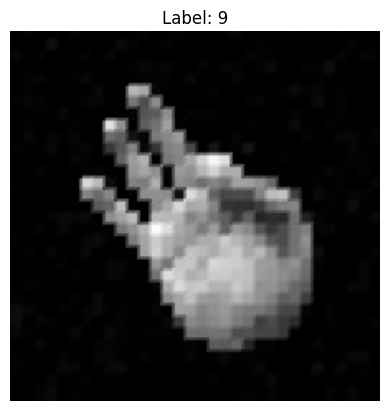

In [56]:
sign_dataset.show_sample(4571)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class ConvAutoencoder(nn.Module):
    def __init__(self, in_channels=1):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=2, padding=1),  # -> (16, H/2, W/2)
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # -> (32, H/4, W/4)
            nn.ReLU(True)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (16, H/2, W/2)
            nn.ReLU(True),
            nn.ConvTranspose2d(16, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (1, H, W)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class ConvAutoencoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, in_channels=1, epochs=20, lr=1e-3, batch_size=64):
        self.in_channels = in_channels
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = ConvAutoencoder(in_channels=in_channels).to(self.device)

    def fit(self, X, y=None):
        X = self._prepare_data(X)
        dataset = torch.utils.data.TensorDataset(X)
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.MSELoss()

        for epoch in range(self.epochs):
            for batch in loader:
                x_batch = batch[0]
                optimizer.zero_grad()
                output = self.model(x_batch)
                loss = criterion(output, x_batch)
                loss.backward()
                optimizer.step()
        return self

    def transform(self, X):
        X = self._prepare_data(X)
        with torch.no_grad():
            encoded = self.model.encoder(X)
        return encoded.cpu().numpy()

    def inverse_transform(self, X_encoded):
        X_encoded = torch.tensor(X_encoded, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            decoded = self.model.decoder(X_encoded)
        return decoded.cpu().numpy()

    def _prepare_data(self, X):
        # Convert from (N, H, W, C) to (N, C, H, W) if needed
        if X.ndim == 4 and X.shape[-1] in [1, 3]:
            X = np.transpose(X, (0, 3, 1, 2))
        X = torch.tensor(X, dtype=torch.float32).to(self.device)
        return X



In [ ]:
# Example with grayscale 28x28 images
from sklearn.model_selection import train_test_split

# X.shape should be (N, 28, 28) or (N, 28, 28, 1)
X = ...  # Your image data as NumPy array, values scaled to [0,1]
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

autoenc = ConvAutoencoderWrapper(in_channels=1, epochs=10)
autoenc.fit(X_train)

# Encoded representation (low-dimensional feature maps)
X_encoded = autoenc.transform(X_test)

# Reconstruct images
X_reconstructed = autoenc.inverse_transform(X_encoded)

## Prediction Stub

You will need to provide a function that can be used to make predictions using your final trained model. 

**IMPORTANT**

1. The name of your prediction function must be `leader_board_predict_fn`
2. Your prediction function should be able take as input a 4-D numpy array of shape [batch_size,1,128,128] and produce predictions in the form of a 1-D numpy array of shape [batch_size,]. 
3. Predictions for each image should be an integer in the range 0-35, that is `0` for the digit $0$, `1` for the digit $1$, .... , `9` for the digit $9$, `10` for the letter $a$, `11` for the letter $b$, ..., `35` for the letter $z$.
4. Your prediction function should internally load your trained model and take care of any data transformations that you need.

Below we provide an implementation of the `leader_board_predict_fn` function, in which we show how a trained model can be loaded (from the weights saved on the disk) for making predictions. This example is for PyTorch, but you are free to use any framework of your choice for your model. The only requirement is that this function should accept a numpy array (with the proper shape) as the input and should produce a numpy array (with the proper shape) as the output. What you do internally is up to you.

Note that the model that we load here is not properly trained and so its performance is very bad. This example is only for showing you how a model can be loaded in PyTorch and how predictions can be made.

In [19]:
def leader_board_predict_fn(input_batch):
    """
    Function for making predictions using your trained model.
    
    Args:
        input_batch (numpy array): Input images (4D array of shape 
                                   [batch_size, 1, 128, 128])
        
    Returns:
        output (numpy array): Predictions of the your trained model 
                             (1D array of int (0-35) of shape [batch_size, ])
    """
    prediction = None
    
    batch_size, channels, height, width = input_batch.shape
    
       
    ### BEGIN EXAMPLE 
    
    # Load the network definition
    from dummy_network import DummyNetwork
    
    # Instantiate the network and set the data type
    dummy_network = DummyNetwork().float()
    
    # Load the saved weights from the disk
    dummy_network.load_state_dict(torch.load("dummy_weights.pt"))
    
    # Set the network to evaluation mode
    dummy_network.eval()
    
    # VERY IMPORTANT
    # Convert the input batch to a torch Tensor and set
    # the data type to the same type as the network
    input_batch = torch.from_numpy(input_batch).float()
       
    # A forward pass with the input batch produces a batch of logits
    # In the network that we use here, Softmax is not applied to the output
    # This may be different for your network.
    logits = dummy_network(input_batch)
    
    # Final classification predictions are taken by taking an argmax over the logits
    # The prediction is converted to a numpy array
    prediction = torch.argmax(logits, dim=1).numpy()

    ### END EXAMPLE 

    # Replace the entire section between ### BEGIN EXAMPLE and ### END EXAMPLE 
    # with your implementation
    
    # YOUR CODE HERE (please remove 'raise NotImplementedError()')
    raise NotImplementedError()
    
    assert prediction is not None, "Prediction cannot be None"
    assert isinstance(prediction, np.ndarray), "Prediction must be a numpy array"

    return prediction

## Evaluation

Your final model will be evaluated on a hidden test set containing images similar to the dataset that you are provided with.

For evaluating the performance of your model, we will use the normalized [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) metric from sklearn. This is simply the percentage of correct predictions that your model makes for all the images of the hidden test set. Hence, if all the predictions are correct, the score is 1.0 and if all predictions are incorrect, the score is 0.0. We will use the sklearn metric so that the accuracy function is agnostic to the machine learning framework you use.

In [20]:
from sklearn.metrics import accuracy_score
  
def accuracy(dataset_path, max_batches=30):
    """
    Calculates the average prediction accuracy.
    
    IMPORTANT
    =========
    In this function, we use PyTorch only for loading the data. When your `leader_board_predict_fn`
    function is called, we pass the arguments to it as numpy arrays. The output of `leader_board_predict_fn`
    is also expected to be a numpy array. So, as long as your `leader_board_predict_fn` function takes
    numpy arrays as input and produces numpy arrays as output (with the proper shapes), it does not
    matter what framework you used for training your network or for producing your predictions.
    
    Args:
        dataset_path (str): Path of the dataset directory
        
    Returns:
        accuracy (float): Average accuracy score over all images (float in the range 0.0-1.0)
    """

    # Create a Dataset object
    sign_lang_dataset = SignLangDataset(csv_file="labels.csv", root_dir=dataset_path)

    # Create a Dataloader
    sign_lang_dataloader = DataLoader(sign_lang_dataset, 
                                      batch_size=64,
                                      shuffle=True, 
                                      drop_last=True,
                                      num_workers=0)
    
    # Calculate accuracy for each batch
    accuracies = list()
    for batch_idx, sample in enumerate(sign_lang_dataloader):
        x = sample["image"].numpy()
        y = sample["label"].numpy()
        prediction = leader_board_predict_fn(x)
        accuracies.append(accuracy_score(y, prediction, normalize=True))
        
        # We will consider only the first 30 batches
        if batch_idx == (max_batches - 1):
            break

    assert len(accuracies) == max_batches
    
    # Return the average accuracy
    mean_accuracy = np.mean(accuracies)
    return mean_accuracy

We will now use your `leader_board_predict_fn` function for calculating the accuracy of your model. We provide the code for testing your loaded model on the visible training data. We will also evaluate your model's performance on the test dataset (the test dataset should only be used for evaluation and is **NOT** to be used for training your model).

In [22]:
def get_score():
    """
    Function to compute scores for train and test datasets.
    """
    import torch
    import numpy as np
    from sklearn.metrics import accuracy_score
    import os
    import pwd
    import time
    import pathlib
    import pandas as pd
    import datetime
    
    ### LEADER BOARD TEST
    seed = 200

    torch.manual_seed(seed)
    np.random.seed(seed)

    # Calculate the accuracy on the training dataset
    # to check that your `leader_board_predict_fn` function 
    # works without any error
    dataset_score = accuracy(dataset_path=DATASET_PATH)

    assert isinstance(dataset_score, float), f"type of dataset_score is {type(dataset_score)}, but it must be float"
    assert 0.0<=dataset_score<=1.0, f"Value of dataset_score is {dataset_score}, but it must be between 0.0 and 1.0"

    # This is your accuracy score on the visible training dataset
    # This is NOT used for the leaderboard.
    print(f"Accuracy score on training data: {dataset_score}")

    # There is a hidden test that will evaluate your trained model on the hidden test set
    # This hidden dataset and the accuracy for this will not be visible to you when you
    # validate this notebook. The accuracy score on the hidden dataset will be used
    # for calculating your leaderboard score.

    seed = 200

    torch.manual_seed(seed)
    np.random.seed(seed)

    user_id = pwd.getpwuid( os.getuid() ).pw_name
    curtime = time.time()
    dt_now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

    try:  # 
        HIDDEN_DATASET_PATH = os.path.expanduser("/data/mlproject22-test-data/sign_lang_test/images")
        hiddendataset_score = accuracy(dataset_path=HIDDEN_DATASET_PATH)

        assert isinstance(hiddendataset_score, float), f"type of dataset_score is {type(dataset_score)}, but it must be float"
        assert 0.0<=hiddendataset_score<=1.0, f"Value of dataset_score is {dataset_score}, but it must be between 0.0 and 1.0"

        print(f"Leaderboard score: {hiddendataset_score}")

        score_dict = dict(
            score_hidden=hiddendataset_score,
            score_train=dataset_score,
            unixtime=curtime,
            user=user_id,
            dt=dt_now,
            comment="",
        )

    except Exception as e:
        err = str(e)
        score_dict = dict(
            score_hidden=float("nan"),
            score_train=dataset_score,
            unixtime=curtime,
            user=user_id,
            dt=dt_now,
            comment=err
        )


    #if list(pathlib.Path(os.getcwd()).parents)[0].name == 'source':
    #    print("we are in the source directory... replacing values.")
    #    print(pd.DataFrame([score_dict]))
    #    score_dict["score_hidden"] = -1
    #    score_dict["score_train"] = -1
    #    print("new values:")
    #    print(pd.DataFrame([score_dict]))

    pd.DataFrame([score_dict]).to_csv("sign_lang.csv", index=False)

    ### LEADER BOARD TEST
    
get_score()

[ WARN:0@222.621] global loadsave.cpp:268 findDecoder imread_('./data/sign_lang_train/MOVPYKZYBLTPZRGU.jpg'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object is not subscriptable